In [42]:
import os, sys
sys.path.append("../..")

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tqdm

from filterflow.base import State
from filterflow.resampling.standard import SystematicResampler, StratifiedResampler, MultinomialResampler
from filterflow.resampling.differentiable import RegularisedTransform, CorrectedRegularizedTransform

This notebook aims to demonstrate the differentiability issue encountered at resampling time. To do this we will compare functionals of the point cloud whilst changing a parameter.

### Discontinuity wrt log_weights

In [31]:
tf.random.set_seed(42)

B = 1
N = 50
D = 1

x = tf.random.normal([B, N, D])
y = tf.constant([[[0.]]])

def make_weights(alpha):
    log_w = np.ones([B, N], dtype=np.float32)
    log2 = np.log(2)
    log_w[:,: N//2] = log2 + np.log(alpha) - np.log(N)
    log_w[:,N//2:] = log2 + np.log(1. - alpha) - np.log(N)
    return tf.constant(log_w)



In [32]:
def log_likelihood(state, observation, resampler, seed=666):
    tf.random.set_seed(seed)
    rv = tfp.distributions.Normal(0., 1.)
    if resampler is not None:
        flags = tf.constant([True])
        state = resampler.apply(state, flags)
        
    log_prob = rv.log_prob(observation-state.particles)
    log_prob = log_prob + state.log_weights
    return tf.reduce_mean(log_prob)
    

In [36]:
linspace = np.linspace(0.1, 0.9, 500)

In [37]:
def get_data(linspace, resampler, x, y):
    res = []
    for alpha in tqdm.tqdm(linspace):
        log_weights = make_weights(alpha)
        state = State(x, log_weights, tf.math.exp(log_weights), tf.constant([0.]))
        res.append(log_likelihood(state, y, resampler).numpy().sum())
    return res
        

In [38]:
systematic = SystematicResampler()
multinomial = MultinomialResampler()
stratified = StratifiedResampler()

epsilon = tf.constant(0.5)
regularized = RegularisedTransform(epsilon)
corrected = CorrectedRegularizedTransform(epsilon)

In [39]:
no_resampling_data = get_data(linspace, None, x, y)
systematic_data = get_data(linspace, systematic, x, y)
multinomial_data = get_data(linspace, multinomial, x, y)
stratified_data = get_data(linspace, stratified, x, y)

regularized_data = get_data(linspace, regularized, x, y)
corrected_data = get_data(linspace, corrected, x, y)



100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:56<00:00,  8.63it/s]


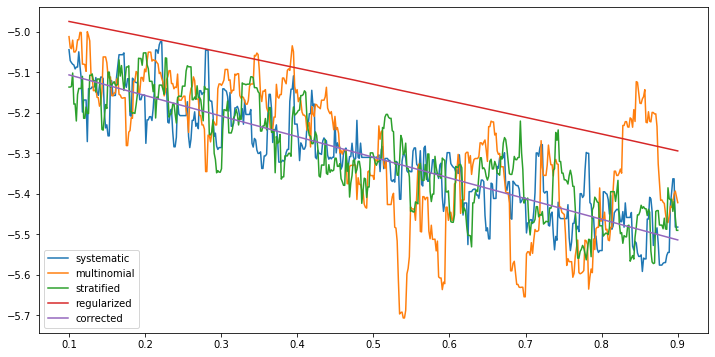

In [44]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(linspace, systematic_data, label='systematic')
ax.plot(linspace, multinomial_data, label='multinomial')
ax.plot(linspace, stratified_data, label='stratified')
ax.plot(linspace, regularized_data, label='regularized')
ax.plot(linspace, corrected_data, label='corrected')
_ = ax.legend()
fig.savefig(os.path.join('./charts/', 'differentiability_illustration.png'))